# Regime Analysis

We will be looking at positive and negative z-score as a way to seperate returns and analyze their results

# Packages

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read Data

In [2]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(os.path.join(parent_path, "data"))
df_path = os.path.join(os.path.join(data_path, "dm_prices.parquet"))

df_raw = pd.read_parquet(path = df_path, engine = "pyarrow")

# Calculate Returns Differential

In [3]:
tickers = ["RSP", "SPY"]

df_spread = (df_raw.query(
    "variable_0 == 'Adj Close' & variable_1 == @tickers").
    drop(columns = ["variable_0"]).
    rename(columns = {"variable_1": "ticker"}).
    pivot(index = "Date", columns = "ticker", values = "value").
    pct_change(periods = 3 * 30).
    dropna().
    assign(
        spread_diff = lambda x: x.SPY - x.RSP,
        z_score = lambda x: (x.spread_diff - x.spread_diff.rolling(window = 30 * 3).mean()) / x.spread_diff.rolling(window = 30 * 3).std())
    [["spread_diff", "z_score"]])

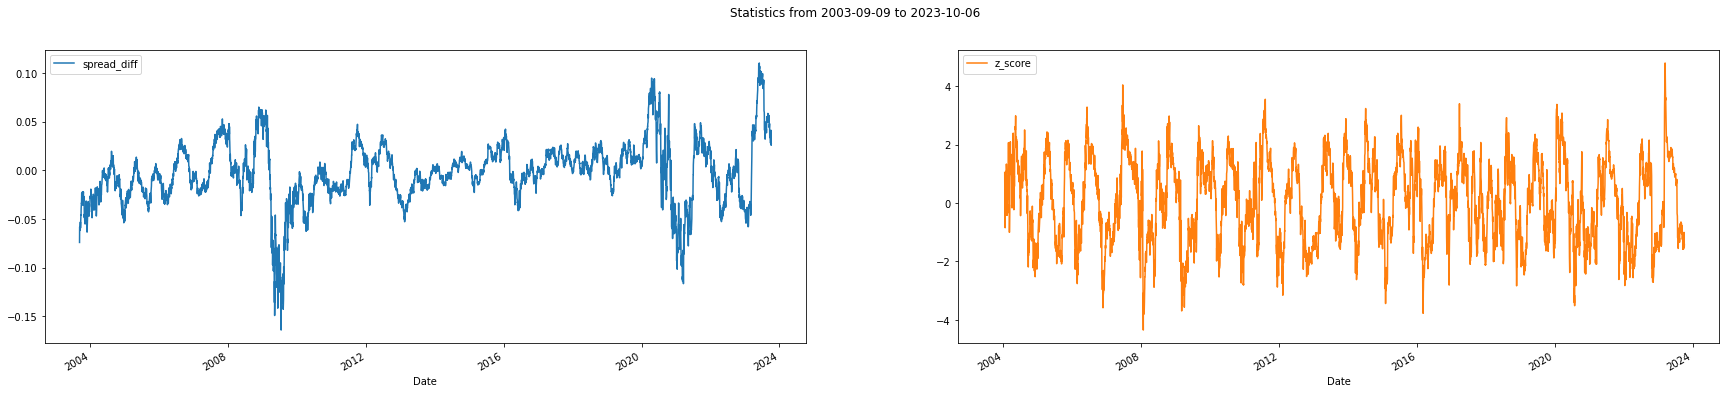

In [4]:
df_spread.plot(
    subplots = True, layout = (1, 2),
    figsize = (30,6),
    title = "Statistics from {} to {}".format(
        df_spread.index.min().date(),
        df_spread.index.max().date()))

plt.show()

# Using positive and negative z-score as a regime analysis

In [5]:
df_zscore = (df_spread.dropna().reset_index().drop(
    columns = ["spread_diff"]).
    assign(z_score_sign = lambda x: np.sign(x.z_score).shift(1)).
    dropna())

df_rtns = (df_raw.query(
    "variable_1 == ['IWB', 'IWM', 'IWV'] & variable_0 == 'Adj Close'").
    drop(columns = "variable_0").
    dropna().
    pivot(index = "Date", columns = "variable_1", values = "value").
    pct_change().
    reset_index().
    melt(id_vars = "Date").
    dropna().
    rename(columns = {"variable_1": "ticker"}))

df_combined = (df_rtns.merge(
    right = df_zscore, how = "inner", on = "Date"))

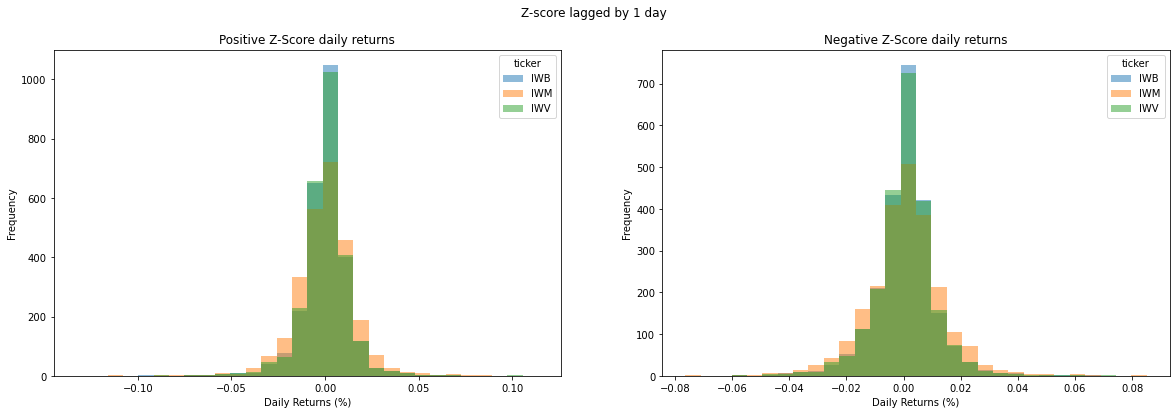

In [6]:
z_score_sign = df_combined.z_score_sign.drop_duplicates().to_list()
col_renamer = {1: "Positive", -1: "Negative"}
fig, axes = plt.subplots(ncols = len(z_score_sign), figsize = (20,6))

for i, sign in enumerate(z_score_sign):
    
    (df_combined.query(
        "z_score_sign == @sign").
        drop(columns = ["z_score", "z_score_sign"]).
        pivot(index = "Date", columns = "ticker", values = "value").
        plot(
            ax = axes[i],
            kind = "hist",
            bins = 30,
            alpha = 0.5,
            title = "{} Z-Score daily returns".format(col_renamer[sign])))
    
    axes[i].set_xlabel("Daily Returns (%)")
    
fig.suptitle("Z-score lagged by 1 day")
plt.show()

We can't look at weekly or monthly returns since we don't know how long these z_score last

In [7]:
df_stats = (df_combined.drop(
    columns = ["Date", "z_score"]).
    groupby(["z_score_sign", "ticker"]).
    agg(["mean", "std", "skew"])
    ["value"].
    reset_index())

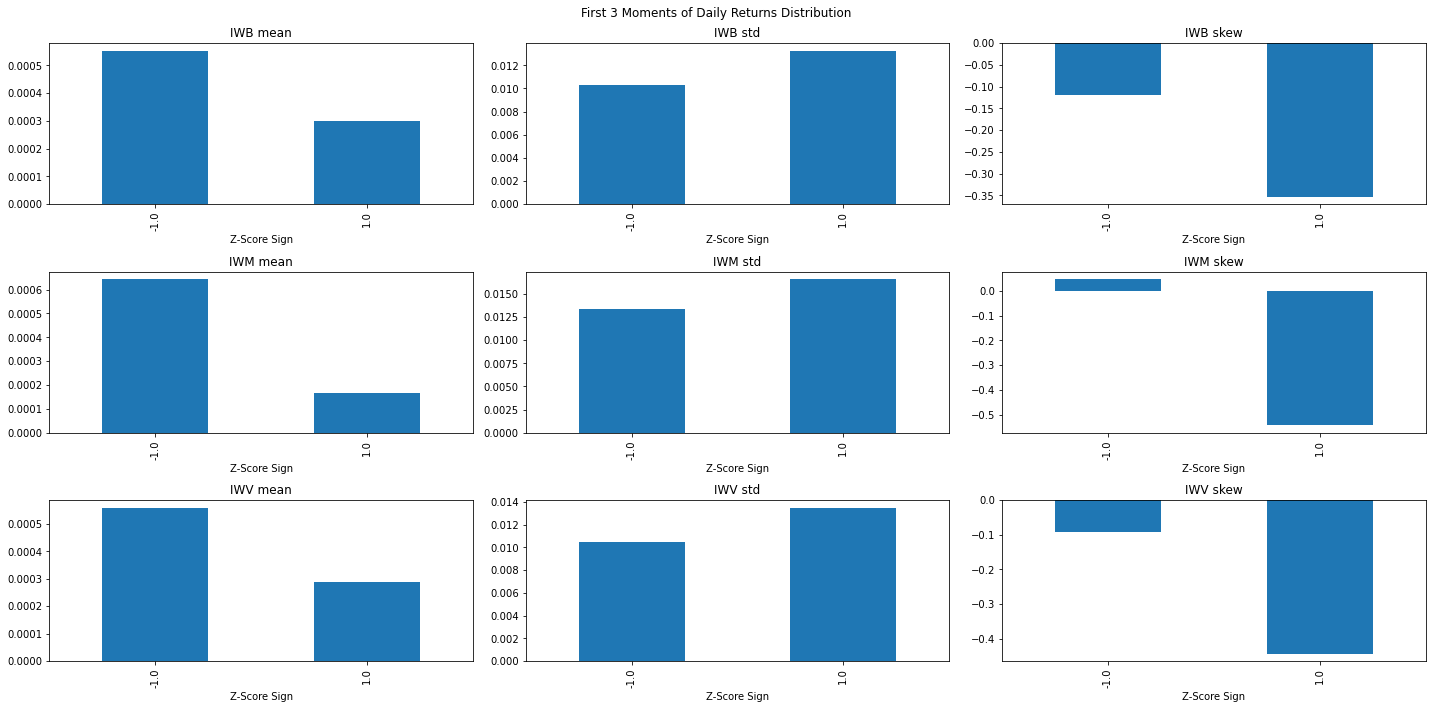

In [8]:
tickers = df_stats.ticker.drop_duplicates().to_list()
stats = ["mean", "std", "skew"]
fig, axes = plt.subplots(ncols = len(tickers), nrows = len(stats), figsize = (20,10))

for i, ticker in enumerate(tickers):
    
    df_tmp = (df_stats.query(
        "ticker == @ticker").
        drop(columns = ["ticker"]).
        rename(columns = {"z_score_sign": "Z-Score Sign"}).
        set_index("Z-Score Sign"))
    
    for j, stat in enumerate(stats):
        
        (df_tmp[
            [stat]].
            plot(
                kind = "bar",
                ax = axes[i,j],
                legend = False,
                title = "{} {}".format(ticker, stat)))
        
fig.suptitle("First 3 Moments of Daily Returns Distribution")
plt.tight_layout()
plt.show()

Recall that these stats may look like they are going against what we are looking for but negative z-score is when equal weight spx is catching up to cap weight spx which can only be done by smaller capitalization members rising. The idea is that we are trying to catch the postive to negative and then remain sitting in the negative z-score. We can see that comparatively the negative z-score beats the positive z-score in most stats

Let's break the z-scores into quantiles and then examine the results

In [9]:
count = 4

df_z_quantiles = (df_zscore.drop(
    columns = ["z_score_sign"]).
    assign(
        quantiles = lambda x: pd.qcut(x.z_score, q = count),
        quantile_name = lambda x: pd.qcut(x.z_score, q = count, labels = ["q{}".format(i+1) for i in range(count)])).
    drop(columns = ["z_score"]))

df_combined = (df_rtns.merge(
    right = df_z_quantiles, how = "inner", on = ["Date"]))

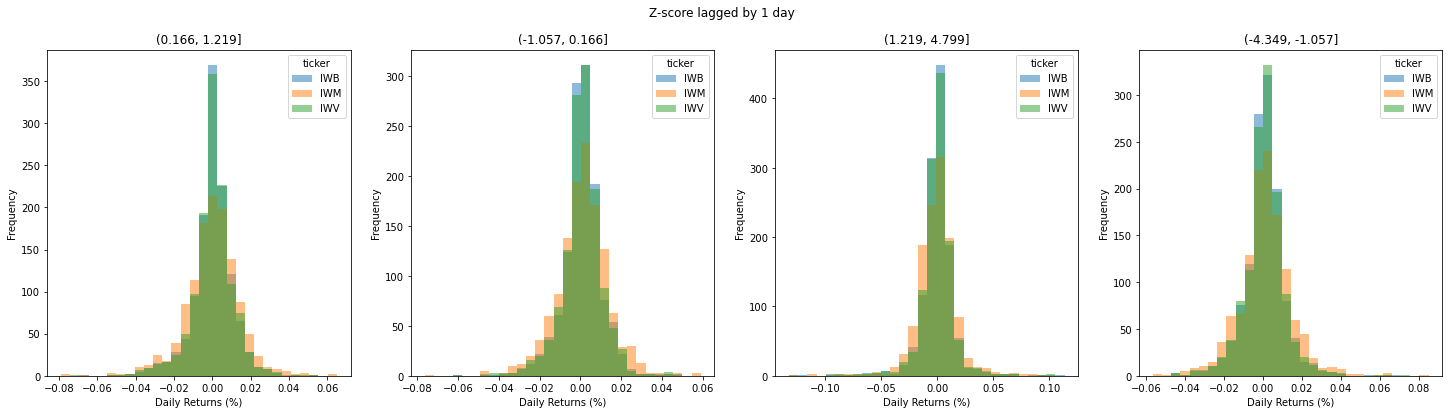

In [10]:
quantiles = df_combined.quantile_name.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(quantiles), figsize = (25,6))

for i, quantile in enumerate(quantiles):
    
    df_plot = (df_combined.query(
        "quantile_name == @quantile"))
    
    title = df_plot.quantiles.iloc[0]
    (df_plot[
        ["Date", "ticker", "value"]].
        pivot(index = "Date", columns = "ticker", values = "value").
        plot(
            ax = axes[i],
            kind = "hist",
            bins = 30,
            alpha = 0.5,
            title = title))
    
    axes[i].set_xlabel("Daily Returns (%)")
    
fig.suptitle("Z-score lagged by 1 day")
plt.show()

In [11]:
df_stats = (df_combined.drop(
    columns = ["Date", "quantile_name"]).
    groupby(["quantiles", "ticker"]).
    agg(["mean", "std", "skew"])
    ["value"].
    reset_index())

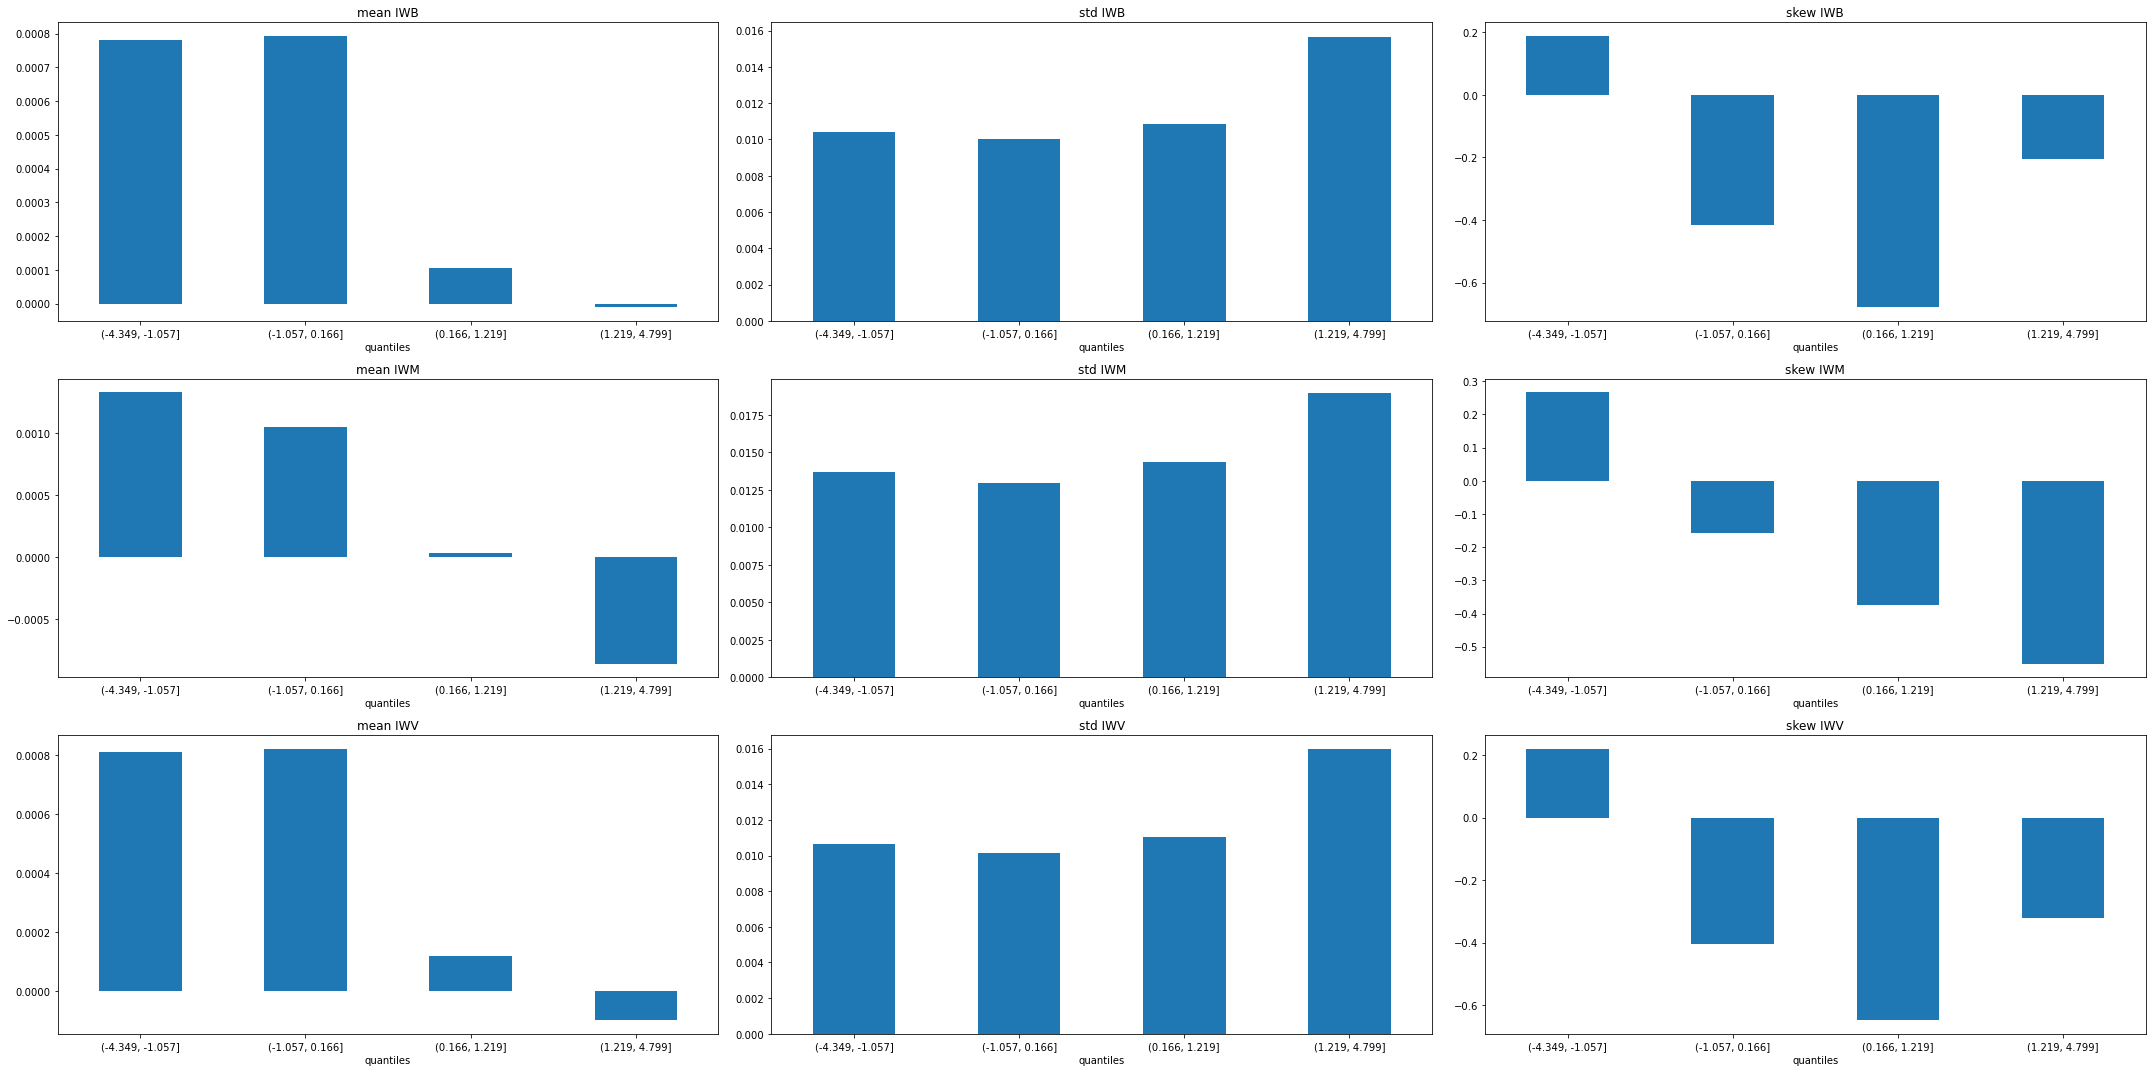

In [12]:
tickers = df_stats.ticker.drop_duplicates().to_list()
stats = ["mean", "std", "skew"]
fig, axes = plt.subplots(ncols = len(tickers), nrows = len(stats), figsize = (30,15))

for i, ticker in enumerate(tickers):
    
    df_tmp = (df_stats.query(
        "ticker == @ticker").
        drop(columns = ["ticker"]).
        set_index("quantiles"))
    
    for j, stat in enumerate(stats):
        
        (df_tmp[
            [stat]].
            plot(
                ax = axes[i,j],
                kind = "bar",
                rot = 0,
                legend = False,
                title = "{} {}".format(stat, ticker)))
        
plt.tight_layout()

# Finding how long regimes last

In [13]:
df_z_regime_change = (df_zscore.set_index(
    "Date").
    drop(columns = ["z_score"]).
    pct_change().
    dropna().
    query("z_score_sign != 0"))

df_regime_name = (df_z_regime_change.assign(
    regime = ["regime{}".format(i + 2) for i in range(len(df_z_regime_change))]).
    drop(columns = ["z_score_sign"]).
    reset_index())

df_regimes = (df_zscore.merge(
    right = df_regime_name, how = "outer", on = "Date").
    fillna(method = "ffill").
    fillna("regime1"))

df_regime_duration = (df_regimes.drop(
    columns = ["Date", "z_score"]).
    assign(periods = 1).
    groupby(["z_score_sign", "regime"]).
    agg("count").
    reset_index())

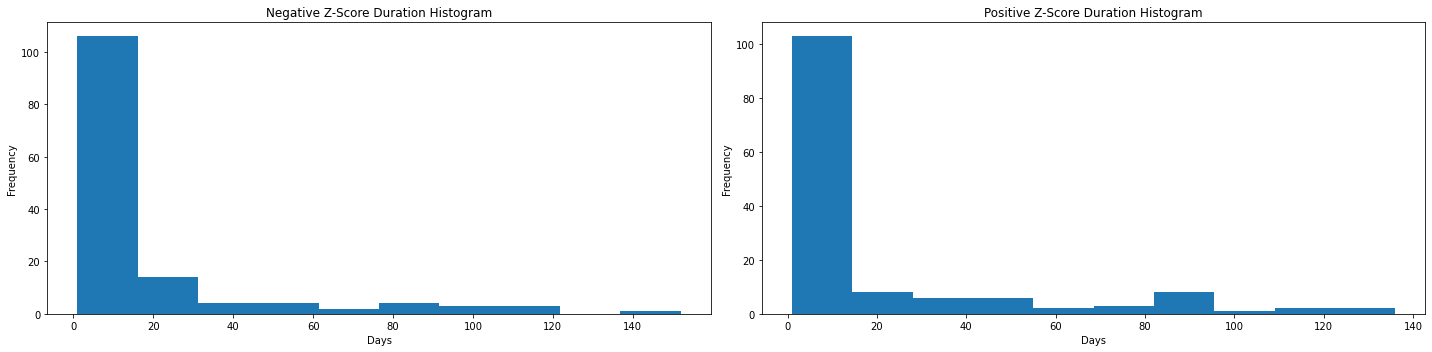

In [14]:
z_score_sign = df_regime_duration.z_score_sign.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = len(z_score_sign), figsize = (20,5))
col_renamer = {1: "Positive", -1: "Negative"}

for i, sign in enumerate(z_score_sign):
    
    (df_regime_duration.query(
        "z_score_sign == @sign").
        drop(columns = ["z_score_sign", "regime"]).
        plot(
            kind = "hist",
            ax = axes[i],
            bins = 10,
            legend = False,
            title = "{} Z-Score Duration Histogram".format(col_renamer[sign])))
    
    axes[i].set_xlabel("Days")

plt.tight_layout()
plt.show()

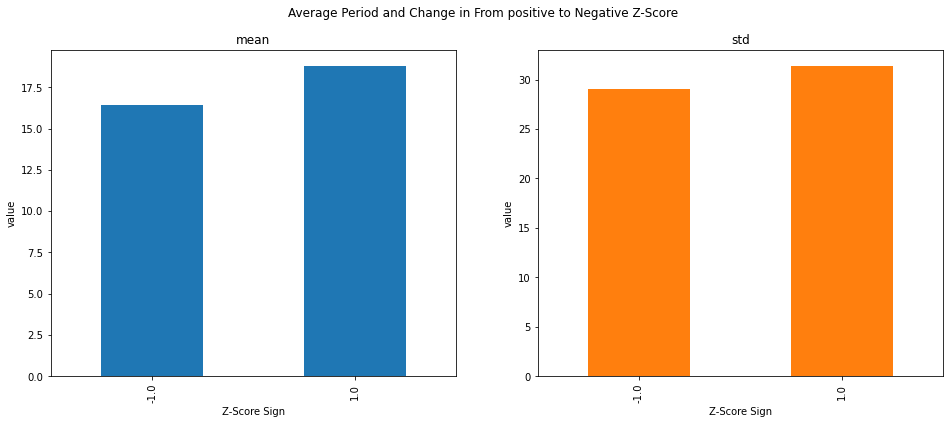

In [15]:
(df_regime_duration.drop(
    columns = ["regime"]).
    rename(columns = {"z_score_sign": "Z-Score Sign"}).
    groupby("Z-Score Sign").
    agg(["mean", "std"])
    ["periods"].
    plot(
        kind = "bar",
        subplots = True,
        layout = (1,2),
        legend = False,
        figsize = (16,6),
        ylabel = "value",
        title = "Average Period and Change in From positive to Negative Z-Score"))

plt.show()